In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def extract_hog_features(image, image_size=(128, 128)):
    resized_image = cv2.resize(image, image_size)
    features = hog(
        resized_image,
        orientations=9,
        pixels_per_cell=(12, 12),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features

In [3]:
def load_dataset_with_hog(root_dir, image_size=(128, 128)):
    X, y = [], []
    label_map = {}

    for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        label_map[idx] = class_name

        for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            features = extract_hog_features(img, image_size)
            X.append(features)
            y.append(idx)

    return np.array(X), np.array(y), label_map


In [4]:
dataset_path = '/kaggle/input/screws/augmented_dataset/screw'
X, y, label_map = load_dataset_with_hog(dataset_path, image_size=(128, 128))

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


Processing thread_top: 100%|██████████| 460/460 [00:04<00:00, 99.83it/s] 


In [5]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001]  
}

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [6]:
final_model = SVC(**grid_search.best_params_)
final_model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))

SVC(C=1, kernel='poly')


Test Accuracy: 0.6260869565217392

Classification Report:
                   precision    recall  f1-score   support

             good       0.55      0.64      0.59        99
manipulated_front       0.84      0.76      0.80        96
     scratch_head       0.57      0.58      0.58        96
     scratch_neck       0.69      0.66      0.68       100
      thread_side       0.59      0.53      0.56        92
       thread_top       0.54      0.58      0.56        92

         accuracy                           0.63       575
        macro avg       0.63      0.62      0.63       575
     weighted avg       0.63      0.63      0.63       575

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy (CV): 0.5000


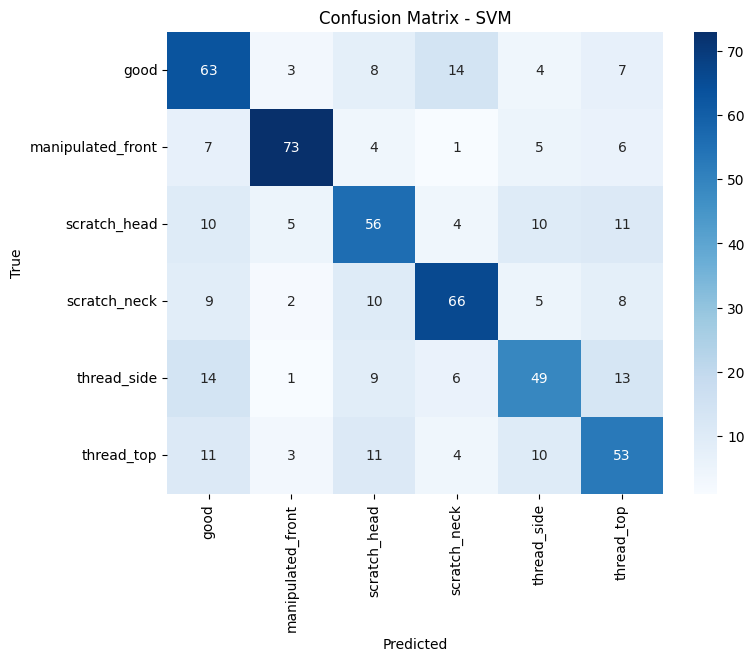

In [7]:
y_pred = final_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[label_map[i] for i in sorted(label_map)]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in sorted(label_map)],
            yticklabels=[label_map[i] for i in sorted(label_map)])

print("Best parameters:", grid_search.best_params_)
print("Best Accuracy (CV): {:.4f}".format(grid_search.best_score_))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM")
plt.show()


In [8]:
import joblib

# Lưu mô hình SVC vào file
model_output_path = 'final_screw_model.pkl'
joblib.dump(final_model, model_output_path)

print(f"\n✅ Model đã được lưu tại: {model_output_path}")



✅ Model đã được lưu tại: final_screw_model.pkl
